In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
import time
import re
import gspread
from oauth2client.service_account import ServiceAccountCredentials

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn tools
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor 
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#pandas show all columns
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('useless-machine-learning-a9027a9eb367.json', scope)

# authorize the clientsheet 
gc = gspread.authorize(creds)

#Pull data from spreadsheet and conver to DataFrame
spreadsheet_key = '1SQpPGP0RYHR4KcOz4XoPFe5y4Mue9D6ilXaAld2dNrI'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("LCS Player Data")
bp_vals = worksheet.get_all_values()

bp = pd.DataFrame(bp_vals[1:], columns=bp_vals[0])

In [3]:
spring_2020 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2020')].reset_index(drop = True)
summer_2020 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2020')].reset_index(drop = True)
spring_2021 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2021')].reset_index(drop = True)
summer_2021 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2021')].reset_index(drop = True)

In [4]:
lcs_spring_2020 = pd.read_csv('LCS 2020 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2020 = pd.read_csv('LCS 2020 Summer - Player Stats - OraclesElixir.csv')
lcs_spring_2021 = pd.read_csv('LCS 2021 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2021 = pd.read_csv('LCS 2021 Summer - Player Stats - OraclesElixir.csv')

In [5]:
full_spring_2020 = spring_2020.merge(lcs_spring_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2020 = summer_2020.merge(lcs_summer_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_spring_2021 = spring_2021.merge(lcs_spring_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2021 = summer_2021.merge(lcs_summer_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])

In [6]:
total = pd.concat([full_spring_2021, full_summer_2021, full_spring_2020, full_summer_2020], ignore_index=True)

In [7]:
total = total[['Name', 'Split', 'Year', 'Position', 'Rank', 'Player', 'GP', 'W%', 
                  'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
                  'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

total['W%'] = total['W%'].str.replace('%', '').astype('float')
total['KS%'] = total['KS%'].str.replace('%', '').astype('float')
total['KP'] = total['KP'].str.replace('%', '').astype('float')
total['DTH%'] = total['DTH%'].str.replace('%', '').astype('float')
total['FB%'] = total['FB%'].str.replace('%', '').astype('float')
total['CS%P15'] = total['CS%P15'].str.replace('%', '').astype('float')
total['DMG%'] = total['DMG%'].str.replace('%', '').astype('float')
total['GOLD%'] = total['GOLD%'].str.replace('%', '').astype('float')

total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

In [8]:
total['K'] = total['K']/total['GP']
total['A'] = total['A']/total['GP']
total['D'] = total['D']/total['GP']
total.drop('GP', axis = 1, inplace = True)

In [9]:
adc = total[total['Position'] == 'ADC']

features = ['W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']

### Correlation Matrix

In [10]:
regressor = RandomForestRegressor(n_estimators=500)

x_adc = adc[features].to_numpy()
y_adc = adc[['Rank']].to_numpy()
y_adc = y_adc.reshape(y_adc.shape[0], )
regressor.fit(x_adc, y_adc)
adc_ind = np.argsort(regressor.feature_importances_)[::-1]
for i in adc_ind:
    print(f"{features[i]}: {regressor.feature_importances_[i]:.4f}")

W%: 0.5793
DPM: 0.1213
KP: 0.0888
A: 0.0351
WPM: 0.0181
WCPM: 0.0162
DMG%: 0.0156
KS%: 0.0145
GOLD%: 0.0136
FB%: 0.0116
GD10: 0.0115
XPD10: 0.0105
KDA: 0.0104
CSD10: 0.0101
D: 0.0100
CS%P15: 0.0096
CSPM: 0.0092
DTH%: 0.0053
K: 0.0053
EGPM: 0.0040


<AxesSubplot:>

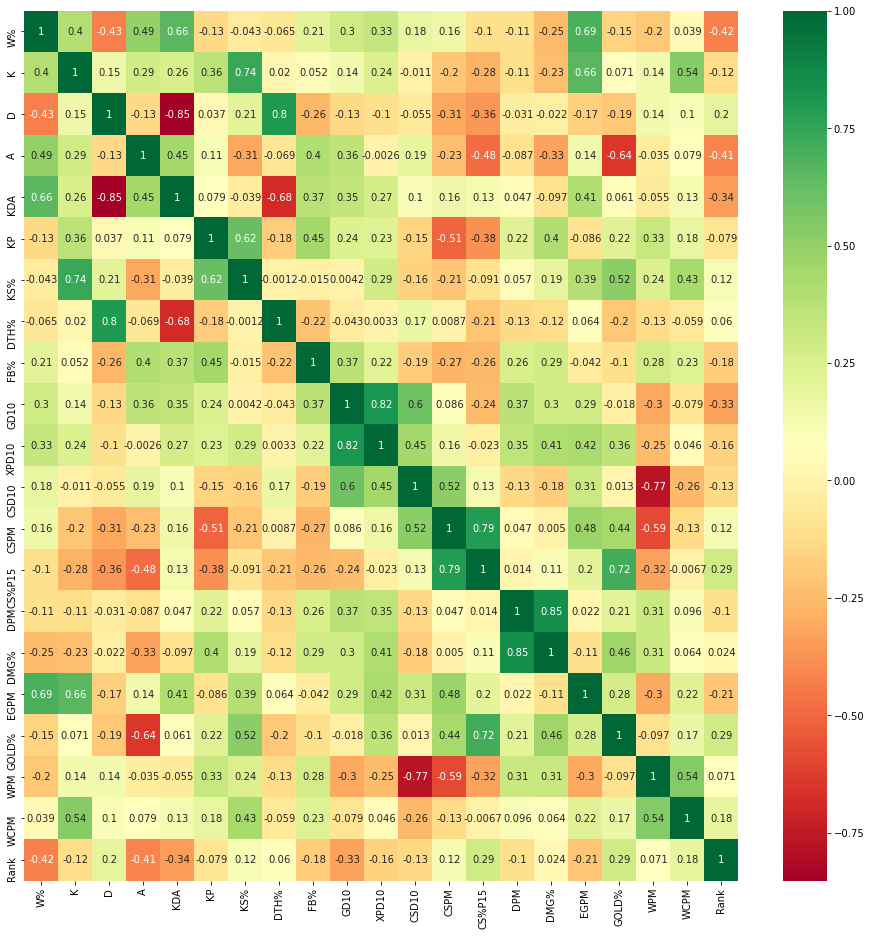

In [11]:
adc_corr = adc[features + ["Rank"]]

fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
sns.heatmap(adc_corr.corr(), annot=True, cmap="RdYlGn")

In [12]:
adc_features = ['W%', 'K', 'A', 'KDA', 'KP', 'DPM', 'XPD10']

In [13]:
means = []
for i in adc_features: 
    means.append(adc[i].mean())

for j, k in enumerate(adc_features): 
    adc.loc[:,k] = adc[k].apply(lambda x: (x - means[j])/means[j])

### Normalizing and train test splitting data

In [14]:
X_adc = adc[adc_features].values
y_adc = adc[['Rank']].values

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_adc)
 
# Generating the standardized values of X
X_adc = PredictorScalerFit.transform(X_adc)
 
# Split the data into training and testing set
X_train_adc, X_test_adc, y_train_adc, y_test_adc = train_test_split(X_adc, y_adc, test_size=0.3, random_state=42)

### Linear Regression Results

In [15]:
lin_regressor = LinearRegression()  
lin_regressor.fit(X_train_adc, y_train_adc)
lin_pred = lin_regressor.predict(X_test_adc)
df1 = pd.DataFrame({'Actual': y_test_adc.flatten(), 'Predicted': lin_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, lin_pred)))

Mean Absolute Error: 0.5736265076402463
Mean Squared Error: 0.47194584278069085
Root Mean Squared Error: 0.6869831459218565


### Decision Tree Results

In [30]:
dec_regressor = DecisionTreeRegressor(random_state = 0, max_depth=6)
dec_regressor.fit(X_train_adc, y_train_adc)
dec_pred = dec_regressor.predict(X_test_adc)
df2 = pd.DataFrame({'Actual': y_test_adc.flatten(), 'Predicted': dec_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, dec_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, dec_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, dec_pred)))

Mean Absolute Error: 0.49756588017610165
Mean Squared Error: 0.40506678289091474
Root Mean Squared Error: 0.6364485704995454


### KNN Results

In [17]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(X_train_adc, y_train_adc)
knn_pred = knn_regressor.predict(X_test_adc)
df3 = pd.DataFrame({'Actual': y_test_adc.flatten(), 'Predicted': knn_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, knn_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, knn_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, knn_pred)))

Mean Absolute Error: 0.6101190476190477
Mean Squared Error: 0.7306547619047619
Root Mean Squared Error: 0.8547834590729759


### SVR Results

In [18]:
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.fit(X_train_adc, y_train_adc)
svr_pred = svr_regressor.predict(X_test_adc)
df4 = pd.DataFrame({'Actual': y_test_adc.flatten(), 'Predicted': svr_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, svr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, svr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, svr_pred)))

Mean Absolute Error: 0.471309793279247
Mean Squared Error: 0.447518141161524
Root Mean Squared Error: 0.6689679672163115


### ANN Results

In [19]:
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units = 5, input_dim = len(adc_features), kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model.fit(X_train_adc, y_train_adc, batch_size = 10, epochs = 50, verbose=1)

Epoch 1/50
40/40 [==============================] - 0s 930us/step - loss: 4.5700
Epoch 2/50
40/40 [==============================] - 0s 999us/step - loss: 4.2224
Epoch 3/50
40/40 [==============================] - 0s 863us/step - loss: 3.5391
Epoch 4/50
40/40 [==============================] - 0s 958us/step - loss: 2.5605
Epoch 5/50
40/40 [==============================] - 0s 1ms/step - loss: 1.6580
Epoch 6/50
40/40 [==============================] - 0s 955us/step - loss: 1.0869
Epoch 7/50
40/40 [==============================] - 0s 1ms/step - loss: 0.7911
Epoch 8/50
40/40 [==============================] - 0s 936us/step - loss: 0.6590
Epoch 9/50
40/40 [==============================] - 0s 906us/step - loss: 0.5929
Epoch 10/50
40/40 [==============================] - 0s 934us/step - loss: 0.5541
Epoch 11/50
40/40 [==============================] - 0s 881us/step - loss: 0.5260
Epoch 12/50
40/40 [==============================] - 0s 855us/step - loss: 0.5095
Epoch 13/50
40/40 [==========

In [20]:
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData = pd.DataFrame(columns = ['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber += 1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units = 5, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer = 'normal'))
 
            # Compiling the model
            model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test - model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData = SearchResultsData.append(pd.DataFrame(data = [[TrialNumber, str(batch_size_trial) + '-' + str(epochs_trial), 100-MAPE]],
                                                                    columns = ['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 

In [21]:
ResultsData = FunctionFindBestParams(X_train_adc, y_train_adc, X_test_adc, y_test_adc)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 59.6497376759847
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 64.1142679585351
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 65.01674063148953
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 55.34014914716993
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 49.618354055380074
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 63.21390592862689
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 63.90502261263983
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 66.11024732627565
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 25.22468617747701
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 63.609812846259466
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 64.70095799082802
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 66.14387255339395
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 14.430093802216035
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 49.03267837824329
15 Parameters: batc

<AxesSubplot:xlabel='Parameters'>

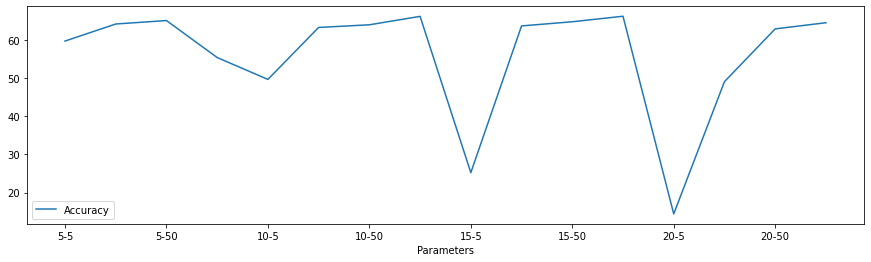

In [22]:
%matplotlib inline
ResultsData.plot(x = 'Parameters', y = 'Accuracy', figsize=(15,4), kind = 'line')

Batch size 10 and epochs = 100 results in the best accuracy

In [23]:
# Fitting the ANN to the Training set
model.fit(X_train_adc, y_train_adc ,batch_size = 10, epochs = 100, verbose=0)

# Generating Predictions on testing data
ann_pred = model.predict(X_test_adc)

# Scaling the test data back to original scale
Test_Data = PredictorScalerFit.inverse_transform(X_test_adc)

TestingData = pd.DataFrame(data = Test_Data, columns = adc_features)
TestingData['Rank'] = y_test_adc
TestingData['Predicted Rank'] = ann_pred

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, ann_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, ann_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, ann_pred)))

Mean Absolute Error: 0.5284612938052132
Mean Squared Error: 0.42849586904053055
Root Mean Squared Error: 0.6545959586191551


### Compare Model Predictions

In [31]:
lcs_spring_2022 = pd.read_csv('LCS 2022 Spring - Player Stats - OraclesElixir.csv')

adc_lcs_2022 = lcs_spring_2022[(lcs_spring_2022['Pos'] == 'ADC') & (lcs_spring_2022['GP'] >= 12)]

adc_lcs_2022 = adc_lcs_2022[['Player', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

adc_lcs_2022['W%'] = adc_lcs_2022['W%'].str.replace('%', '').astype('float')
adc_lcs_2022['KS%'] = adc_lcs_2022['KS%'].str.replace('%', '').astype('float')
adc_lcs_2022['KP'] = adc_lcs_2022['KP'].str.replace('%', '').astype('float')
adc_lcs_2022['DTH%'] = adc_lcs_2022['DTH%'].str.replace('%', '').astype('float')
adc_lcs_2022['FB%'] = adc_lcs_2022['FB%'].str.replace('%', '').astype('float')
adc_lcs_2022['CS%P15'] = adc_lcs_2022['CS%P15'].str.replace('%', '').astype('float')
adc_lcs_2022['DMG%'] = adc_lcs_2022['DMG%'].str.replace('%', '').astype('float')
adc_lcs_2022['GOLD%'] = adc_lcs_2022['GOLD%'].str.replace('%', '').astype('float')

adc_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = adc_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

adc_lcs_2022['K'] = adc_lcs_2022['K']/adc_lcs_2022['GP']
adc_lcs_2022['A'] = adc_lcs_2022['A']/adc_lcs_2022['GP']
adc_lcs_2022['D'] = adc_lcs_2022['D']/adc_lcs_2022['GP']
adc_lcs_2022.drop('GP', axis = 1, inplace = True)

means = []
for i in adc_features: 
    means.append(adc_lcs_2022[i].mean())

for j, k in enumerate(adc_features): 
    adc_lcs_2022.loc[:,k] = adc_lcs_2022[k].apply(lambda x: (x - means[j])/means[j])

X_adc_lcs_sp2022 = adc_lcs_2022[adc_features].values
adc_lcs_sp2022_names = adc_lcs_2022['Player']

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_adc_lcs_sp2022)
 
# Generating the standardized values of X
X_adc_lcs_sp2022 = PredictorScalerFit.transform(X_adc_lcs_sp2022)

adc_lin = lin_regressor.predict(X_adc_lcs_sp2022)
adc_dec = dec_regressor.predict(X_adc_lcs_sp2022)
adc_knn = knn_regressor.predict(X_adc_lcs_sp2022)
adc_svr = svr_regressor.predict(X_adc_lcs_sp2022)
adc_ann = model.predict(X_adc_lcs_sp2022)

In [32]:
adc_lin = pd.DataFrame(adc_lin)
adc_lin.rename(columns={0:'Rank'}, inplace= True)
adc_names = adc_lcs_2022[['Player']].reset_index(drop = True)
adc_final_lin = pd.concat([adc_names, adc_lin], axis=1)
adc_final_lin.sort_values(by='Rank', ascending=True, inplace=True)
adc_final_lin.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(adc_final_lin)):
    adc_final_lin.loc[i, 'Rank'] = initial
    initial += 1

adc_final_lin

,Player,Rank
0,FBI,1.0
1,Hans sama,2.0
2,Berserker,3.0
3,Johnsun,4.0
4,Luger,5.0
5,Lost,6.0
6,Neo,7.0
7,Danny,8.0
8,Tactical,9.0


In [33]:
adc_dec = pd.DataFrame(adc_dec)
adc_dec.rename(columns={0:'Rank'}, inplace= True)
adc_names = adc_lcs_2022[['Player']].reset_index(drop = True)
adc_final_dec = pd.concat([adc_names, adc_dec], axis=1)
adc_final_dec.sort_values(by='Rank', ascending=True, inplace=True)
adc_final_dec.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(adc_final_dec)):
    adc_final_dec.loc[i, 'Rank'] = initial
    initial += 1

adc_final_dec

,Player,Rank
0,Berserker,1.0
1,Danny,2.0
2,FBI,3.0
3,Hans sama,4.0
4,Tactical,5.0
5,Luger,6.0
6,Johnsun,7.0
7,Lost,8.0
8,Neo,9.0


In [34]:
adc_knn = pd.DataFrame(adc_knn)
adc_knn.rename(columns={0:'Rank'}, inplace= True)
adc_names = adc_lcs_2022[['Player']].reset_index(drop = True)
adc_final_knn = pd.concat([adc_names, adc_knn], axis=1)
adc_final_knn.sort_values(by='Rank', ascending=True, inplace=True)
adc_final_knn.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(adc_final_knn)):
    adc_final_knn.loc[i, 'Rank'] = initial
    initial += 1

adc_final_knn

,Player,Rank
0,Berserker,1.0
1,Hans sama,2.0
2,Danny,3.0
3,Johnsun,4.0
4,Lost,5.0
5,Luger,6.0
6,Tactical,7.0
7,FBI,8.0
8,Neo,9.0


In [35]:
adc_svr = pd.DataFrame(adc_svr)
adc_svr.rename(columns={0:'Rank'}, inplace= True)
adc_names = adc_lcs_2022[['Player']].reset_index(drop = True)
adc_final_svr = pd.concat([adc_names, adc_svr], axis=1)
adc_final_svr.sort_values(by='Rank', ascending=True, inplace=True)
adc_final_svr.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(adc_final_svr)):
    adc_final_svr.loc[i, 'Rank'] = initial
    initial += 1

adc_final_svr

,Player,Rank
0,Berserker,1.0
1,Hans sama,2.0
2,FBI,3.0
3,Tactical,4.0
4,Danny,5.0
5,Luger,6.0
6,Lost,7.0
7,Johnsun,8.0
8,Neo,9.0


In [36]:
adc_ann = pd.DataFrame(adc_ann)
adc_ann.rename(columns={0:'Rank'}, inplace= True)
adc_names = adc_lcs_2022[['Player']].reset_index(drop = True)
adc_final_ann = pd.concat([adc_names, adc_ann], axis=1)
adc_final_ann.sort_values(by='Rank', ascending=True, inplace=True)
adc_final_ann.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(adc_final_ann)):
    adc_final_ann.loc[i, 'Rank'] = initial
    initial += 1

adc_final_ann

,Player,Rank
0,Hans sama,1.0
1,FBI,2.0
2,Berserker,3.0
3,Johnsun,4.0
4,Danny,5.0
5,Lost,6.0
6,Neo,7.0
7,Luger,8.0
8,Tactical,9.0


All models outside of dec seem reasonable.

### Combined Results Ensemble Averaging

In [42]:
all_pred = (1/4*knn_pred.reshape(-1,1) +1/4*ann_pred + 1/4*svr_pred.reshape(-1,1) + 1/4*lin_pred.reshape(-1,1))

In [43]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_adc, all_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_adc, all_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_adc, all_pred)))

Mean Absolute Error: 0.5092774187630368
Mean Squared Error: 0.437768095715344
Root Mean Squared Error: 0.6616404580399721


### Predicting for the Spring 2022 LCS Players

In [44]:
final = pd.merge(pd.merge(pd.merge(adc_final_lin, adc_final_ann, on = 'Player'), adc_final_svr, on = 'Player'), adc_final_knn, on = 'Player')
final['Final Rank'] = final.iloc[:].sum(axis = 1)/4
final.sort_values(by = 'Final Rank', ascending = True, inplace = True)
final

,Player,Rank_x,Rank_y,Rank_x,Rank_y,Final Rank
1,Hans sama,2.0,1.0,2.0,2.0,1.75
2,Berserker,3.0,3.0,1.0,1.0,2.00
0,FBI,1.0,2.0,3.0,8.0,3.50
3,Johnsun,4.0,4.0,8.0,4.0,5.00
7,Danny,8.0,5.0,5.0,3.0,5.25
5,Lost,6.0,6.0,7.0,5.0,6.00
4,Luger,5.0,8.0,6.0,6.0,6.25
8,Tactical,9.0,9.0,4.0,7.0,7.25
6,Neo,7.0,7.0,9.0,9.0,8.00
